# Import necessary packages

In [1]:
import qiskit as q
import pec_module as pec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from numpy.linalg import inv
from itertools import product
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

# Connect to ibm select the device to mimic the error

In [2]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
QiskitRuntimeService.save_account(
        channel="ibm_quantum_platform",
        token=token,
        instance=instance,
        set_as_default=True,
        overwrite=True
    )
device_name = "kingston"
dev = "ibm_" + device_name
service = QiskitRuntimeService()
device = service.backend(dev)
noise_model = NoiseModel.from_backend(device)

In [3]:
# # # Load saved credentials
# # service = QiskitRuntimeService()

# # #For real Device
# # device = service.backend("ibm_kyiv")
# # noise_model = NoiseModel.from_backend(device)

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# # Get coupling map from backend
# coupling_map = [[0, 1], [1, 2], [3, 2], [3, 4]]

# #For Aer
# # backend = AerSimulator(noise_model=noise_model,
# #                        coupling_map=coupling_map,
# #                        basis_gates=basis_gates)
# backend = AerSimulator()

# backendqubitNum = backend.num_qubits
# print(backendqubitNum)

In [4]:
# 建立空的 noise model
# noise_model = NoiseModel()

# 加入 CNOT gate 的 depolarizing noise（以 (0,1) 為例）
# cx_error = depolarizing_error(param=0.05, num_qubits=2)  # 1% depolarizing error
# noise_model.add_quantum_error(cx_error, 'cx', [0, 1])

# 加入 measurement 的 readout error（以 qubit 0 為例）
# readout_probs = [[0.95, 0.05], [0.02, 0.98]]  # 機率轉換矩陣
# readout_error = ReadoutError(readout_probs)
# noise_model.add_readout_error(readout_error, [0])
# noise_model.add_readout_error(readout_error, [1])

# 設定模擬器
backend = AerSimulator(noise_model=noise_model)
backendqubitNum = backend.num_qubits
print(backendqubitNum)

34


In [5]:
print("=== All gate errors in the noise model ===")
for key, errors in noise_model._local_quantum_errors.items():
    if isinstance(key, tuple) and len(key) == 2:
        gate, qubits = key
    else:
        gate = key
        qubits = None
    print(f"Gate: {gate}, Qubits: {qubits}")
    for err in errors:
        print(err)

print("\n=== All readout errors in the noise model ===")
for qubits, err in noise_model._local_readout_errors.items():
    print(f"Qubits: {qubits}, Error: {err}")
# print(noise_model)

=== All gate errors in the noise model ===
Gate: x, Qubits: None
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
(30,)
(31,)
(32,)
(33,)
(34,)
(35,)
(36,)
(37,)
(38,)
(39,)
(40,)
(41,)
(42,)
(43,)
(44,)
(45,)
(46,)
(47,)
(48,)
(49,)
(50,)
(51,)
(52,)
(53,)
(54,)
(55,)
(56,)
(57,)
(58,)
(59,)
(60,)
(61,)
(62,)
(63,)
(64,)
(65,)
(66,)
(67,)
(68,)
(69,)
(70,)
(71,)
(72,)
(73,)
(74,)
(75,)
(76,)
(77,)
(78,)
(79,)
(80,)
(81,)
(82,)
(83,)
(84,)
(85,)
(86,)
(87,)
(88,)
(89,)
(90,)
(91,)
(92,)
(93,)
(94,)
(95,)
(96,)
(97,)
(98,)
(99,)
(100,)
(101,)
(102,)
(103,)
(104,)
(105,)
(106,)
(107,)
(108,)
(109,)
(110,)
(111,)
(112,)
(113,)
(114,)
(115,)
(116,)
(117,)
(118,)
(119,)
(120,)
(121,)
(122,)
(123,)
(124,)
(125,)
(126,)
(127,)
(128,)
(129,)
(130,)
(131,)
(132,)
(133,)
(134,)
(135,)
(136,)
(137,)
(138,)
(139,)
(140,)
(141,)
(142,)
(143,)
(144,)
(145,)
(146,)
(147,)
(148,)
(1

# Do 2-qubits measurement PEC

In [6]:
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg = QuantumRegister(2, 'q')
creg = ClassicalRegister(2, 'c')
q0_init = {}
q1_init = {}

for i in range (2):
    #rho0 state |0>
    InitCirZero = QuantumCircuit(qreg, creg)
    #rho1 state |1>
    InitCirOne = QuantumCircuit(qreg, creg)
    InitCirOne.x(i)
    #rho2 state |0>+|1>
    InitCirPlus = QuantumCircuit(qreg, creg)
    InitCirPlus.h(i)
    #rho3 state |0>+i|1>
    InitCirRight = QuantumCircuit(qreg, creg)
    InitCirRight.h(i)
    InitCirRight.s(i)
    
    if i == 0:
        q0_init = {'q0zero':InitCirZero, 'q0one':InitCirOne, 'q0plus':InitCirPlus, 'q0right':InitCirRight}
    else:
        q1_init = {'q1zero':InitCirZero, 'q1one':InitCirOne, 'q1plus':InitCirPlus, 'q1right':InitCirRight}

# Store the initial circuits in a dictionary
InitialState = {}
for q0, q0state in q0_init.items():
    for q1, q1state in q1_init.items():
        initcomb = q.circuit.QuantumCircuit.compose(q0state, q1state)
        InitialState.update({f'{q0}_{q1}':initcomb})

In [7]:
# Store the measurement circuits in a dictionary
Measurement = {}
pau = ['I', 'X', 'Y', 'Z']
for i in pau:
    for j in pau:
        # meascomb = Pauli('I' * (backendqubitNum-2) + j + i) 
        meascomb = Pauli(j + i) 
        Measurement.update({f'meas{j}{i}':meascomb})
print(Measurement)

{'measII': Pauli('II'), 'measXI': Pauli('XI'), 'measYI': Pauli('YI'), 'measZI': Pauli('ZI'), 'measIX': Pauli('IX'), 'measXX': Pauli('XX'), 'measYX': Pauli('YX'), 'measZX': Pauli('ZX'), 'measIY': Pauli('IY'), 'measXY': Pauli('XY'), 'measYY': Pauli('YY'), 'measZY': Pauli('ZY'), 'measIZ': Pauli('IZ'), 'measXZ': Pauli('XZ'), 'measYZ': Pauli('YZ'), 'measZZ': Pauli('ZZ')}


In [8]:
job = {}
estimator = Estimator(mode=backend)
estimator.options.default_shots = 100000
for MeasName, Measure in Measurement.items():
    for InitName, Initial in InitialState.items():
        CirTran = q.compiler.transpile(Initial, backend=backend, optimization_level=0)
        job.update({f'{InitName}_{MeasName}':estimator.run([(CirTran, Measure)])})

In [9]:
result_origin = []
for index, job_name in job.items():
    res = job_name.result()
    result_origin.append(res[0].data.evs)
result_origin

[array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(-0.00266997),
 array(0.00508995),
 array(0.98194018),
 array(0.00310997),
 array(0.00388996),
 array(0.00108999),
 array(0.98148019),
 array(0.00136999),
 array(0.00246998),
 array(0.00188998),
 array(0.98226018),
 array(0.00049),
 array(0.00186998),
 array(-0.00506995),
 array(0.98132019),
 array(-0.00422996),
 array(-0.00154998),
 array(-0.00732993),
 array(0.00086999),
 array(0.98142019),
 array(-0.00176998),
 array(-0.00464995),
 array(-0.00078999),
 array(0.98202018),
 array(0.00094999),
 array(0.00043),
 array(-0.00025),
 array(0.98054019),
 array(0.00498995),
 array(0.00062999),
 array(-0.00450995),
 array(0.9804202),
 array(0.98150018),
 array(-0.98142019),
 array(-0.00670993),
 array(0.00226998),
 array(0.98178018),
 array(-0.98122019),
 array(0.00640994),
 array(0.00402996),
 arra

In [10]:
g = np.array(result_origin).reshape(16, 16)
g

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-2.66997330e-03,  5.08994910e-03,  9.81940181e-01,
         3.10996890e-03,  3.88996110e-03,  1.08998910e-03,
         9.81480185e-01,  1.36998630e-03,  2.46997530e-03,
         1.88998110e-03,  9.82260177e-01,  4.89995100e-04,
         1.86998130e-03, -5.06994930e-03,  9.81320187e-01,
        -4.22995770e-03],
       [-1.54998450e-03, -7.32992670e-03,  8.69991300e-04,
         9.81420186e-01, -1.76998230e-03, -4.64995350e-03,
        -7.89992100e-04,  9.82020180e-01,  9.49990500e-04,
         4.29995700e-04, -2.49997500e-04,  9.80540195e-01,
         4.98995010e-03,  6.29993700e-04, -4.50995490e-03,
         9.80420196e-01],
       [ 9.81500185e-01, -9.81420186e

In [11]:
#Create State Preparation Matrix A
A_single = np.array([[1, 1, 1, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [1,-1, 0, 0]])
A = np.kron(A_single, A_single)
#print(A)

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
#print(A_inv)
B = np.matmul(g, A_inv)
B_inv = inv(B)
# print(B_inv)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])
a = {'I':a_i, 'X':a_x, 'Y':a_y, 'Z':a_z}
aa = {}
qq = {}
for f, first in a.items():
    for s, second in a.items():
        a_mix = np.kron(first, second)
        aa.update({f'a_{s}{f}':a_mix})
        q_mix = np.matmul(a_mix, B_inv)
        qq.update({f'{s}{f}':q_mix})
        
        # print(f'a_{f}{s}:', a_mix)
        # print(f'{f}{s}:', q_mix)
        # print('\n')
print(qq)

{'II': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'XI': array([[-1.86261645e-03,  1.02053108e+00, -4.22878532e-04,
         1.28877496e-03, -3.51806120e-04, -2.06186011e-04,
         2.23176797e-03, -1.68586161e-03,  3.63598359e-03,
        -3.27767145e-03,  3.34987219e-03, -5.11412482e-03,
         6.50869837e-04, -9.20107000e-04, -1.58974060e-03,
         2.88949395e-03]]), 'YI': array([[ 3.85205368e-03, -3.97465731e-03,  1.01471795e+00,
        -2.18460413e-03, -4.67302483e-03,  4.99342826e-03,
         5.94592460e-03,  1.97967093e-03, -7.00257901e-03,
         1.20402459e-02,  8.57444111e-03, -4.38675013e-05,
         6.42637321e-04, -1.55583927e-03, -2.86186266e-04,
        -7.63203533e-04]]), 'ZI': array([[-1.64540411e-04,  3.22786873e-04, -3.12051396e-03,
         1.01888055e+00, -1.55747655e-04, -2.67741785e-04,
         2.16939638e-03,  5.14809050e-04, -7.96151776e-07,
         8.44472590e-04,  3.14139230e-03, -7.12807499e-04,
         1.0390813

In [12]:
#Observable = Oq1 Oq0
Observable = ['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ']
IdealMeasurement = {}
for obs in Observable:
    # IdealObservable = SparsePauliOp(['I' * (backendqubitNum)], coeffs=[qq[obs][0][0]])
    IdealObservable = SparsePauliOp(['II'], coeffs=[qq[obs][0][0]])
    for i in range(1, len(Observable)):
        # IdealObservable += SparsePauliOp([('I' * (backendqubitNum-2) + Observable[i])], coeffs=[qq[obs][0][i]])
        IdealObservable += SparsePauliOp([(Observable[i])], coeffs=[qq[obs][0][i]])
    IdealMeasurement.update({f'meas{obs}':IdealObservable})
IdealMeasurement

{'measII': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
  0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]),
 'measXI': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[-1.86261645e-03+0.j,  1.02053108e+00+0.j, -4.22878532e-04+0.j,
   1.28877496e-03+0.j, -3.51806120e-04+0.j, -2.06186011e-04+0.j,
   2.23176797e-03+0.j, -1.68586161e-03+0.j,  3.63598359e-03+0.j,
  -3.27767145e-03+0.j,  3.34987219e-03+0.j, -5.11412482e-03+0.j,
   6.50869837e-04+0.j, -9.20107000e-04+0.j, -1.58974060e-03+0.j,
   2.88949395e-03+0.j]),
 'measYI': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[ 3.85205368e-03+0.j, -3.97465731e-03+0.j,  1.01471795e+00+0.j,
  -2.18460413e-03+0

In [13]:
len(IdealMeasurement)

16

# Do 2-qubits CZ PEC

In [14]:
#Build each set of circuits with Initialstates, cz gate, measurements
#CZ gate
CZgate = QuantumCircuit(qreg, creg)
CZgate.cz(0, 1)
Circuit = {}
for InitName, Initial in InitialState.items():
    circuit = q.circuit.QuantumCircuit.compose(Initial, CZgate)
    Circuit.update({f'{InitName}':circuit})
Circuit

{'q0zero_q1zero': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bd570>,
 'q0zero_q1one': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bc400>,
 'q0zero_q1plus': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bf2b0>,
 'q0zero_q1right': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3beda0>,
 'q0one_q1zero': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bfa30>,
 'q0one_q1one': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bc490>,
 'q0one_q1plus': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bc460>,
 'q0one_q1right': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3be830>,
 'q0plus_q1zero': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3be8f0>,
 'q0plus_q1one': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3be170>,
 'q0plus_q1plus': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bccd0>,
 'q0plus_q1right': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x78ab9b3bd0f

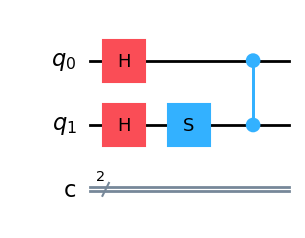

In [15]:
Circuit['q0plus_q1right'].draw(output='mpl') 

In [ ]:
estimator.options.default_shots = 1024
batched_cz = []
for MeasName, Measure in IdealMeasurement.items():
    for CirName, Cir in Circuit.items():
        CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
        batched_cz.append((CirTran, Measure))
job_cz = estimator.run(batched_cz)

In [ ]:
res = job_cz.result()
result_cz_origin = [res[i].data.evs for i in range(256)]
g_cz = np.array(result_cz_origin).reshape(16, 16)
g_cz

# result_cz_origin = []
# res = job_cz.result()
# result_cz_origin.append(res[0].data.evs for i in range(256))
# g_cz = np.array(result_cz_origin).reshape(16, 16)
# g_cz

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [ 7.63736447e-03, -3.54010010e-03,  9.98419371e-01,
        -2.13134118e-03, -3.76095412e-03, -9.12224642e-05,
        -1.00384602e+00, -1.91772397e-03, -4.91983873e-03,
        -3.03783436e-03, -1.94850880e-03, -6.16038395e-04,
        -5.95294693e-03, -1.37800785e-02, -5.48374877e-03,
        -1.18309832e-02],
       [ 6.02069502e-03,  1.03085265e-02,  5.15641726e-03,
         9.98946761e-01, -3.15097746e-04,  1.16812604e-02,
         4.40081853e-03, -9.91094269e-01,  4.56475196e-03,
         1.68570380e-02,  9.80759152e-03, -4.91609397e-03,
        -3.44622945e-03,  1.33204766e-02, -6.35249462e-03,
         8.59285874e-03],
       [ 1.00013018e+00, -9.98724124e

In [26]:
#Calculate Readout Matrix by the quation Uerror = B^-1 * g_cz * A^-1
ErrorCZ = np.matmul(np.matmul(B_inv, g_cz), A_inv)
print(ErrorCZ)
ErrorCZ_inv = inv(ErrorCZ)
# print(ErrorCZ_inv)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.77625199e-03 -3.76194454e-03 -3.65324095e-03  3.20694688e-03
  -5.85497834e-03  8.39538523e-03  8.77399728e-03 -3.23403367e-03
  -1.52046431e-02  5.12633708e-03 -8.54142859e-05  5.68825124e-03
   2.64683865e-03  1.01960625e+00 -2.57504534e-03  6.68023406e-03]
 [ 1.08242903e-02 -3.71721899e-03 -3.29255505e-03 -6.23796097e-03
   5.67692625e-03  1.00302492e-02 -2.46588121e-02 -6.59965967e-03
  -1.98293805e-03 -1.51470555e-02  1.14849915e-02 -1.13004951e-02
   1.88192372e-03 -4.80954383e-03  1.00851306e+00  1.23209877e-03]
 [ 5.30888326e-04  7.59994389e-03 -6.36926142e-04  1.01829075e+00
  -4.95045730e-05  9.87219565e-03 -4.25660631e-03 -6.77552664e-04
  -2.76296118e-03  8.92489107e-05  4.75535663e-03 -2.22766436e-04
   7.97

In [27]:
import numpy as np
import csv
# 將矩陣存成CSV檔案
filename = 'matrix_ErrorCZ.csv'
np.savetxt(filename, ErrorCZ, delimiter=",", fmt="%.10e")
print(f"矩陣已成功存成CSV檔案：{filename}")

矩陣已成功存成CSV檔案：matrix_ErrorCZ.csv


# Build PTM of the Ideal Ucz

In [28]:
#Construct Ideal Ucz
pauli = ["I", "X", "Y", "Z"]
pauli_pair = {}
for i in pauli:
    for j in pauli:
        pauli_pair.update({f"{i}{j}":np.array(Pauli(f"{i}{j}").to_matrix())})

def evolution(gate, state):
    return np.matmul(np.matmul(gate, state), np.conj(gate).T)
        
CZ = Operator(CZgate).data
IdealCZ = np.ones((16,16),  dtype=complex)
i = 0
for index1, matrix1 in pauli_pair.items():
    j = 0
    for index2, matrix2 in pauli_pair.items():
        applycz = evolution(CZ, matrix1)
        element = np.matmul(matrix2, applycz)
        IdealCZ[i][j] = np.round(np.trace(element)/4)
        j+=1
    i+=1 

print(IdealCZ)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.

In [29]:
import numpy as np
import csv
# 將矩陣存成CSV檔案
filename = 'matrix_IdealCZ.csv'
np.savetxt(filename, IdealCZ, delimiter=",", fmt="%.10e")
print(f"矩陣已成功存成CSV檔案：{filename}")

矩陣已成功存成CSV檔案：matrix_IdealCZ.csv


In [30]:
#Construct Error channel
LambdaError = np.matmul(inv(IdealCZ), ErrorCZ)
# print(np.round(LambdaError2))
print(LambdaError.real)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.14332622e-03  1.06556021e+00  1.04561298e-03  3.50027440e-04
   6.29393725e-03  1.30918430e-02 -1.39353807e-02 -7.41570197e-03
   1.65515932e-03 -2.34456240e-03  7.23183288e-03 -3.37656027e-03
  -4.42302857e-03 -3.80921221e-03 -4.62817937e-03  9.31105848e-03]
 [ 1.02694924e-03 -1.59409963e-03  1.05905063e+00 -7.70936722e-04
   1.16438416e-02 -4.58061309e-03 -1.58955053e-02 -1.07780254e-02
   3.85589183e-03  2.00675568e-04  1.31324659e-02 -4.31563329e-03
   3.24255663e-03 -1.79188754e-03  8.65461320e-04  5.44956394e-03]
 [ 5.30888326e-04  7.59994389e-03 -6.36926142e-04  1.01829075e+00
  -4.95045730e-05  9.87219565e-03 -4.25660631e-03 -6.77552664e-04
  -2.76296118e-03  8.92489107e-05  4.75535663e-03 -2.22766436e-04
   7.97

# Pauli Twirling

In [31]:
pauli_transfer = {}
for channel, matrix in pauli_pair.items():
    new_matrix = evolution(CZ, matrix)
    for new_channel, comp_matrix in pauli_pair.items():
        if np.array_equal(new_matrix, comp_matrix) or np.array_equal(new_matrix, -comp_matrix):
            pauli_transfer.update({channel:new_channel})
print(pauli_transfer)

{'II': 'II', 'IX': 'ZX', 'IY': 'ZY', 'IZ': 'IZ', 'XI': 'XZ', 'XX': 'YY', 'XY': 'YX', 'XZ': 'XI', 'YI': 'YZ', 'YX': 'XY', 'YY': 'XX', 'YZ': 'YI', 'ZI': 'ZI', 'ZX': 'IX', 'ZY': 'IY', 'ZZ': 'ZZ'}


In [32]:
# Function to generate measurement circuits
def generate_pauli_circuits(index):
    circuits = {
        "I": QuantumCircuit(2, 2),
        "X": QuantumCircuit(2, 2),
        "Y": QuantumCircuit(2, 2),
        "Z": QuantumCircuit(2, 2),
    }
    # X-measurement
    circuits["X"].x(index)
    # Y-measurement
    circuits["Y"].y(index)
    # Z-measurement
    circuits["Z"].z(index)

    return circuits

# Store the measurement circuits in a dictionary
PauliTwirling = {}
for q0_label, q0 in generate_pauli_circuits(0).items():
    for q1_label, q1 in generate_pauli_circuits(1).items():
        pauli_comb = q.circuit.QuantumCircuit.compose(q0, q1)
        PauliTwirling.update({f"{q0_label}{q1_label}": pauli_comb})
print(PauliTwirling)

{'II': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b40a0>, 'IX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b54e0>, 'IY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b43d0>, 'IZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b4c70>, 'XI': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b4e20>, 'XX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b4ac0>, 'XY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b49d0>, 'XZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e16b4310>, 'YI': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e237ff40>, 'YX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e237f8e0>, 'YY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e237c7c0>, 'YZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x78b1e237c970>, 'ZI': <qiskit.circuit.quantumcircuit.QuantumCircuit

In [33]:
Twirling_circuit_set = {}
for firstPauli, secondPauli in pauli_transfer.items():
    Twirling_circuit = {}
    for InitName, Initial in InitialState.items():
        AddPauli = q.circuit.QuantumCircuit.compose(Initial, PauliTwirling[firstPauli])
        AddCZ = q.circuit.QuantumCircuit.compose(AddPauli, CZgate)
        AddPauliInverse = q.circuit.QuantumCircuit.compose(AddCZ, PauliTwirling[secondPauli])
        Twirling_circuit.update({InitName:AddPauliInverse})
    Twirling_circuit_set.update({firstPauli:Twirling_circuit})

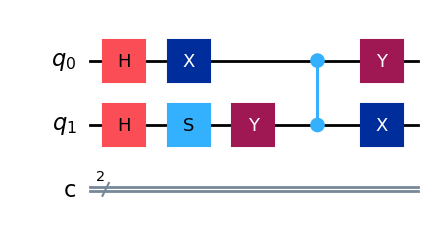

In [34]:
Twirling_circuit_set['XY']['q0plus_q1right'].draw(output='mpl') 

In [40]:
Twirling_job = {}
for pauli, circuit_set in Twirling_circuit_set.items():
    batched_twrl = []
    # job = {}
    for MeasName, Measure in IdealMeasurement.items():
        for CirName, Cir in circuit_set.items():
            CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
            # job.update({f'{CirName}_{MeasName}':estimator.run([(CirTran, Measure)])})
            batched_twrl.append((CirTran, Measure))
    # Twirling_job.update({pauli:job})
    Twirling_job.update({pauli:estimator.run(batched_twrl)})

In [47]:
Sum_twirling = np.zeros((16,16))
for pauli, job in Twirling_job.items():
    # for index, job_name in job.items():
        # res = job_name.result()
        # result_each_twirling.append(res[0].data.evs)
    res = job.result()
    data = [r.data.evs for r in res]
    g_twirling = np.array(data).reshape(16, 16)
    # ErrorCZ_twirling = np.matmul(np.matmul(B_inv, g_twirling), A_inv)
    ErrorCZ_twirling = np.matmul(g_twirling, A_inv)
    Sum_twirling = Sum_twirling + ErrorCZ_twirling

Avg_twirling = Sum_twirling/16
Avg_gateError = np.matmul(inv(IdealCZ), Avg_twirling)
Avg_gateError

array([[ 1.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 1.53156384e-03+0.j,  9.99851337e-01+0.j,  8.05855957e-04+0.j,
        -6.06766212e-04+0.j,  3.08628621e-03+0.j,  5.87590619e-03+0.j,
        -6.01133631e-03+0.j, -1.39017296e-03+0.j,  8.72576552e-04+0.j,
        -1.15700610e-03+0.j,  4.00594459e-03+0.j, -1.96025990e-03+0.j,
        -1.07790368e-03+0.j, -2.45846251e-03+0.j, -5.28017833e-03+0.j,
         3.40144593e-03+0.j],
       [ 1.56604931e-03+0.j, -2.02550046e-03+0.j,  9.95584262e-01+0.j,
        -1.98135469e-03+0.j,  9.09118038e-04+0.j,  3.14001117e-03+0.j,
        -3.62078242e-03+0.j, -3.24575459e-03+0.j,  7.59027861e-04+0.j,
        -1.328869

In [48]:
# c = T * α -> α = T^-1 * c
c = np.diag(Avg_gateError)

P_mtrx = [Pauli(i+j).to_matrix() for i, j in product(pau, repeat=2)]
trnscoe = []
for bas in P_mtrx:
    bascoe = []
    for tw in P_mtrx:
        mult = np.matmul(np.matmul(tw, bas), tw)
        if np.array_equal(mult, bas):
            bascoe.append(1)
        elif np.array_equal(mult, -bas):
            bascoe.append(-1)
    trnscoe.append(bascoe)

alpha = np.matmul(inv(trnscoe), c)
inv_alpha = 1/alpha
inv_alpha2 = np.matmul(inv(trnscoe), 1/c)
print(alpha)
print(inv_alpha)
print(inv_alpha2)
sum(inv_alpha2)

[ 9.98220507e-01+0.j  1.45922159e-03+0.j -9.27721331e-04+0.j
  6.56958495e-04+0.j  4.01506419e-04+0.j -1.48088872e-04+0.j
  4.20025679e-04+0.j  3.16854301e-04+0.j  1.29188239e-04+0.j
  1.01275670e-04+0.j  2.43778901e-05+0.j -5.35657510e-04+0.j
 -2.30877764e-04+0.j -7.06338816e-06+0.j -2.44874874e-04+0.j
  3.64368909e-04+0.j]
[ 1.00178267e+00+0.j  6.85296878e+02+0.j -1.07790989e+03-0.j
  1.52216618e+03+0.j  2.49062020e+03+0.j -6.75270186e+03-0.j
  2.38080682e+03+0.j  3.15602470e+03+0.j  7.74064270e+03+0.j
  9.87403979e+03+0.j  4.10207773e+04+0.j -1.86686452e+03-0.j
 -4.33129628e+03-0.j -1.41575116e+05-0.j -4.08371828e+03-0.j
  2.74447126e+03+0.j]
[ 1.00178714e+00+0.j -1.46569754e-03+0.j  9.33222156e-04+0.j
 -6.62203662e-04+0.j -4.04211472e-04+0.j  1.50000121e-04+0.j
 -4.21543362e-04+0.j -3.15649062e-04+0.j -1.30272863e-04+0.j
 -1.00006503e-04+0.j -2.66536300e-05+0.j  5.37846792e-04+0.j
  2.32383323e-04+0.j  5.00898280e-06+0.j  2.47599096e-04+0.j
 -3.66960940e-04+0.j]


np.complex128(0.9999999999999998+0j)

In [49]:
def OutputMatrix(matrix, filename):
    # 將每列轉為空格分隔的字串
    matrix_lines = [''.join(f"{val:>9.5f}" for val in row) for row in matrix]
    
    # 繪製圖片
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axis('off')  # 不顯示座標軸
    
    # 建立表格
    table_data = []
    for i in range(16):
        row = []
        for j in range(16):
            val = matrix[i][j]
            formatted = f"{val.real:.6f}"
            row.append(formatted)
        table_data.append(row)
    
    # 建立表格物件
    table = ax.table(cellText=table_data,  loc='center',  cellLoc='center')
    
    # 樣式調整
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            cell = table[i, j]
            val = matrix[i][j]
            
            # 主對角線粗體
            if 0.8 <= abs(val) < 1.2:
                cell.set_text_props(weight='bold')
    
            # 紅色標註：介於 0.01 ~ 0.1 或 -0.01 ~ -0.1
            if 0.01 <= abs(val) < 0.1:
                cell.set_text_props(color='red')
    
    # 儲存為圖片
    plt.savefig(f"{filename}.png", bbox_inches='tight', dpi=300)
    plt.close()

In [ ]:
OutputMatrix(Avg_gateError, "parameter_matrix\Avg_CZgateError_1Wshots")

In [ ]:
filename = 'matrixCZ_TwirlingError.csv'
np.savetxt(filename, Avg_gateError, delimiter=",", fmt="%.10e")

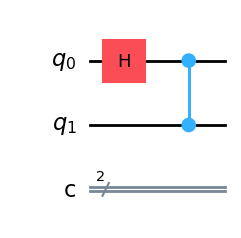

In [51]:
Bell_circuit = QuantumCircuit(qreg, creg)
Bell_circuit.h(0)
Bell_circuit.cz(0, 1)
Bell_circuit.draw('mpl')

In [52]:
def add_twirling_circuit(circuit):
    twir_cir_set = {}
    for first_pauli, second_pauli in pauli_transfer.items():
        twir_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
        for instr in circuit.data:
            if instr.operation.name == 'cz':
                twir_circuit = QuantumCircuit.compose(twir_circuit, PauliTwirling[first_pauli])     
                twir_circuit.append(instr.operation, instr.qubits, instr.clbits)
                twir_circuit = QuantumCircuit.compose(twir_circuit, PauliTwirling[second_pauli])
            else:
                twir_circuit.append(instr.operation, instr.qubits, instr.clbits)
        twir_cir_set.update({first_pauli:twir_circuit})    
    return twir_cir_set


In [53]:
Bell_cir_twir = add_twirling_circuit(Bell_circuit)
# Bell_cir_twir["XY"].draw("mpl")

In [54]:
def run_bell(times):
    Bell_twir_job = []   
    batched_RdO = []
    batched_Noisy = []
    for i in range(times):      
        # PEC TQG
        batched_TQG = []
        for CirName, Cir in Bell_cir_twir.items():
            CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
            batched_TQG.append((CirTran, Measure))
        Bell_twir_job.append(estimator.run(batched_TQG))
        # PEC RdO
        RCirTran = q.compiler.transpile(Bell_circuit, backend=backend, optimization_level=0)
        batched_RdO.append((RCirTran, IdealMeasurement['measZZ']))
        # Noisy
        BCirTran = q.compiler.transpile(Bell_circuit, backend=backend, optimization_level=0)
        batched_Noisy.append((BCirTran, Measurement['measZZ']))
    Noisy_job = estimator.run(batched_Noisy)
    RdO_job = estimator.run(batched_RdO)
    return Noisy_job, RdO_job, Bell_twir_job

def avg_expectation(jobset, weight):
    average = []
    for job in jobset:
        result_mitigate = job.result()
        result = [res.data.evs for res in result_mitigate]
        average.append(sum(expct*invc for expct, invc in zip(result, weight)))
    return average

In [55]:
job_noisy, job_rdo, job_tqg = run_bell(50)

IOStream.flush timed out
IOStream.flush timed out


In [56]:
result_noisy = job_noisy.result()
result_rdo = job_rdo.result()
NoisyExpectation = [result_noisy[i].data.evs for i in range(50)]
ReadoutExpectation = [result_rdo[i].data.evs for i in range(50)]
TwoQubitGateExpectation = np.real(avg_expectation(job_tqg, inv_alpha2))

print('Noisy_Expectation:\n', NoisyExpectation)
print('Readout_Expectation:\n', ReadoutExpectation)
print('TwoQubitGate_Expectation:\n', TwoQubitGateExpectation)

Noisy_Expectation:
 [array(-0.00013), array(-0.00122999), array(0.00260997), array(-0.00370996), array(0.00364996), array(0.00228998), array(0.00039), array(0.00013), array(0.00023), array(-0.00198998), array(0.00184998), array(0.00052999), array(0.00052999), array(0.00110999), array(0.00302997), array(-0.00178998), array(0.00252997), array(6.99993e-05), array(0.00344997), array(0.00318997), array(0.00064999), array(0.00292997), array(0.00274997), array(-0.00332997), array(0.00035), array(0.00246998), array(-0.00914991), array(0.00500995), array(-0.00035), array(0.00262997), array(-2.99997e-05), array(0.00152998), array(-0.00182998), array(-0.00282997), array(-0.00248998), array(-0.00284997), array(-0.00266997), array(-0.00342997), array(0.00312997), array(0.00452995), array(-0.01088989), array(0.00216998), array(0.00102999), array(0.00378996), array(-0.00080999), array(0.00050999), array(-0.00406996), array(-0.00023), array(-0.00130999), array(-0.00316997)]
Readout_Expectation:
 [arra

In [57]:
def plot_expectation_histogram_multi(data_list,  # List of tuples: [(name, data_array, color), ...]
                                     Ideal=0,
                                     bin_width=0.005,
                                     title="Histogram of Expectation Values",
                                     xlabel="Expectation Value",
                                     ylabel="Frequency",
                                     save_path=None):

    # 將所有資料轉為 numpy array
    processed = []
    for name, data, color in data_list:
        data_arr = np.array([x.item() for x in data])
        processed.append((name, data_arr, color))

    # 計算 bins 範圍（依所有資料最大絕對值對稱設 bin）
    max_val = max(abs(arr).max() for (_, arr, _) in processed)
    bins = np.arange(-np.ceil(max_val * 100) / 100 - bin_width,
                     np.ceil(max_val * 100) / 100 + bin_width,
                     bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # 建立圖片
    fig, ax = plt.subplots(figsize=(12, 6))
    # 避免重疊
    width = bin_width * (0.9 / len(processed))  

    legend_patches = []
    legend_lines = []
    all_values = []

    for idx, (name, arr, color) in enumerate(processed):
        hist, _ = np.histogram(arr, bins=bins)
        shift = (idx - len(processed) / 2 + 0.5) * width  # 偏移位置
        ax.bar(bin_centers + shift, hist, width=width, color=color)

        # 統計量
        mean_val = np.mean(arr)
        median_val = np.median(arr)
        var_val = np.var(arr)
        std_val = np.std(arr)

        # Mean 虛線
        ax.axvline(mean_val, color=color, linestyle='--')

        # Legend handle
        legend_patches.append(mpatches.Patch(color=color, label=name))
        legend_lines.append(mlines.Line2D([], [], color=color, linestyle='--', 
                                          label=f"{name} Mean: {mean_val:.4f}"))

        # 文字框
        max_y = max(hist.max() for (_, a, _) in processed)
        text_y = max_y * (1.0 - 0.25 * idx)  # 每組資料往下排
        ax.text(arr.min(), text_y,
                f"Median: {median_val:.4f}\nVariance: {var_val:.4f}\nStd Dev: {std_val:.4f}",
                color=color, fontsize=10, fontweight='bold',
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle="round,pad=0.4", edgecolor=color, facecolor='white', linewidth=1))

        all_values.append(arr)

    # X 軸設定
    all_values_flat = np.concatenate(all_values)
    xticks = np.arange(np.floor(bin_centers.min()*200)/200,
                       np.ceil(bin_centers.max()*200)/200 + bin_width,
                       bin_width)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{x:.3f}' for x in xticks], rotation=45)
    ax.set_xlim(all_values_flat.min() - bin_width, all_values_flat.max() + bin_width)

    # 標題與說明
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)

    # 圖例
    ax.legend(handles=legend_patches + legend_lines, loc='upper center')

    # 理論值
    ax.axvline(Ideal, color='red', linestyle='-')

    # 顯示或儲存
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()

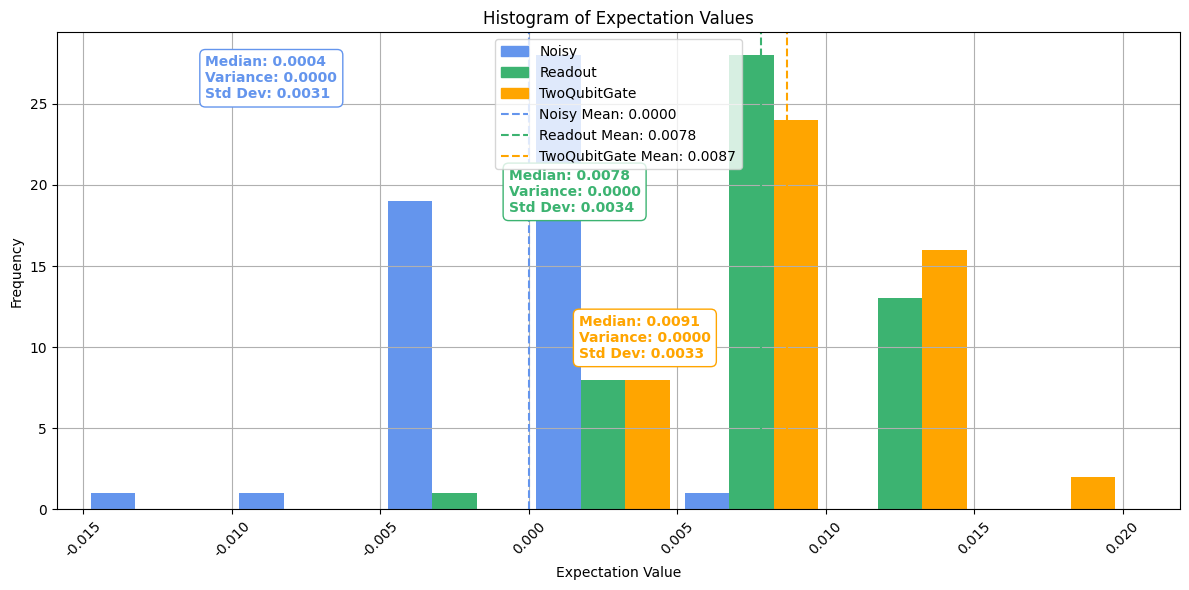

In [58]:
plot_expectation_histogram_multi([("Noisy", NoisyExpectation, "cornflowerblue"),
                                  ("Readout", ReadoutExpectation, "mediumseagreen"),
                                  ("TwoQubitGate", TwoQubitGateExpectation, "orange")], Ideal = 1)
